In [1]:
# Topological Data Analysis for Bird Song Classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display

# Topological Data Analysis libraries
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings('ignore')

# Sklearn for comparison
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

print("Libraries loaded successfully!")
print("Ripser version available for persistent homology")

Libraries loaded successfully!
Ripser version available for persistent homology


In [2]:
# Load the data we prepared in the first notebook
DATA_PATH = Path('../songs/songs')

# List all audio files
audio_files = list(DATA_PATH.rglob('*.flac'))
print(f'Total audio files found: {len(audio_files)}')

# Load metadata
metadata = pd.read_csv('../birdsong_metadata.csv')

# Create dataframe with species info
species_data = []
for file in audio_files:
    file_id = int(file.stem.replace('xc', ''))
    species_data.append({
        'file_id': file_id,
        'filepath': str(file),
        'filename': file.name
    })

audio_df = pd.DataFrame(species_data)
df = audio_df.merge(metadata, on='file_id', how='left')

print(f'\nDataset shape: {df.shape}')
print(f'Number of species: {df["species"].nunique()}')
print(f'\nTop 10 species by count:')
print(df['species'].value_counts().head(10))

Total audio files found: 264

Dataset shape: (264, 12)
Number of species: 85

Top 10 species by count:
species
major          6
montanus       6
palustris      6
caudatus       3
oriolus        3
sibilatrix     3
curruca        3
vulgaris       3
decaocto       3
schoeniclus    3
Name: count, dtype: int64


In [3]:
def extract_topological_features(spectrogram, max_dim=1):
    """
    Extract topological features from a spectrogram using persistent homology
    
    Args:
        spectrogram: 2D numpy array (frequency x time)
        max_dim: Maximum homology dimension to compute (0=components, 1=loops)
    
    Returns:
        Dictionary of topological features
    """
    # Normalize spectrogram to [0, 1]
    spec_normalized = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Sample points from spectrogram (treat as point cloud)
    # Use high-intensity points as our point cloud
    threshold = np.percentile(spec_normalized, 75)  # Top 25% of points
    high_intensity_points = np.argwhere(spec_normalized > threshold)
    
    # If too many points, subsample
    if len(high_intensity_points) > 500:
        indices = np.random.choice(len(high_intensity_points), 500, replace=False)
        high_intensity_points = high_intensity_points[indices]
    
    # Compute persistent homology
    result = ripser(high_intensity_points, maxdim=max_dim)
    diagrams = result['dgms']
    
    # Extract features from persistence diagrams
    features = {}
    
    for dim in range(max_dim + 1):
        diagram = diagrams[dim]
        # Remove infinite points
        diagram = diagram[diagram[:, 1] < np.inf]
        
        if len(diagram) > 0:
            # Persistence = death - birth
            persistence = diagram[:, 1] - diagram[:, 0]
            
            # Statistical features of persistence
            features[f'H{dim}_num_features'] = len(diagram)
            features[f'H{dim}_persistence_mean'] = np.mean(persistence)
            features[f'H{dim}_persistence_std'] = np.std(persistence)
            features[f'H{dim}_persistence_max'] = np.max(persistence)
            features[f'H{dim}_persistence_sum'] = np.sum(persistence)
            
            # Birth and death statistics
            features[f'H{dim}_birth_mean'] = np.mean(diagram[:, 0])
            features[f'H{dim}_death_mean'] = np.mean(diagram[:, 1])
        else:
            # No features found in this dimension
            features[f'H{dim}_num_features'] = 0
            features[f'H{dim}_persistence_mean'] = 0
            features[f'H{dim}_persistence_std'] = 0
            features[f'H{dim}_persistence_max'] = 0
            features[f'H{dim}_persistence_sum'] = 0
            features[f'H{dim}_birth_mean'] = 0
            features[f'H{dim}_death_mean'] = 0
    
    return features, diagrams


def extract_traditional_features(y, sr):
    """Extract traditional audio features for comparison"""
    features = {}
    
    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['mfcc_mean'] = np.mean(mfcc, axis=1)
    features['mfcc_std'] = np.std(mfcc, axis=1)
    
    # Spectral features
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    # Flatten the feature dict
    flat_features = {}
    for key, value in features.items():
        if isinstance(value, np.ndarray):
            for i, v in enumerate(value):
                flat_features[f'{key}_{i}'] = v
        else:
            flat_features[key] = value
    
    return flat_features


print("Feature extraction functions defined!")

Feature extraction functions defined!


In [4]:
# Select top species with enough samples for analysis
species_counts = df['species'].value_counts()
top_species = species_counts[species_counts >= 5].index[:10]  # Top 10 species with 5+ samples

print(f"Analyzing {len(top_species)} species with sufficient samples:")
print(top_species.tolist())

# Filter dataset to these species
df_subset = df[df['species'].isin(top_species)].copy()
print(f"\nTotal samples to analyze: {len(df_subset)}")

# Extract features from all samples
print("\nExtracting topological and traditional features...")

all_topo_features = []
all_trad_features = []
labels = []
filepaths = []

for idx, row in df_subset.iterrows():
    try:
        # Load audio
        y, sr = librosa.load(row['filepath'], sr=22050, duration=10)  # First 10 seconds
        
        # Create mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Extract topological features
        topo_features, _ = extract_topological_features(mel_spec_db)
        all_topo_features.append(topo_features)
        
        # Extract traditional features
        trad_features = extract_traditional_features(y, sr)
        all_trad_features.append(trad_features)
        
        labels.append(row['species'])
        filepaths.append(row['filepath'])
        
        if len(all_topo_features) % 10 == 0:
            print(f"Processed {len(all_topo_features)} samples...")
            
    except Exception as e:
        print(f"Error processing {row['filename']}: {e}")
        continue

print(f"\nSuccessfully extracted features from {len(all_topo_features)} samples!")

# Convert to DataFrames
topo_df = pd.DataFrame(all_topo_features)
trad_df = pd.DataFrame(all_trad_features)
labels_array = np.array(labels)

print(f"\nTopological features shape: {topo_df.shape}")
print(f"Traditional features shape: {trad_df.shape}")

Analyzing 3 species with sufficient samples:
['major', 'montanus', 'palustris']

Total samples to analyze: 18

Extracting topological and traditional features...
Processed 10 samples...

Successfully extracted features from 18 samples!

Topological features shape: (18, 14)
Traditional features shape: (18, 30)


In [5]:
# Split data for classification
from sklearn.model_selection import cross_val_score

print("=" * 60)
print("CLASSIFICATION COMPARISON: Topological vs Traditional Features")
print("=" * 60)

# Prepare data
X_topo = topo_df.values
X_trad = trad_df.values
y = labels_array

# Scale features
scaler_topo = StandardScaler()
scaler_trad = StandardScaler()

X_topo_scaled = scaler_topo.fit_transform(X_topo)
X_trad_scaled = scaler_trad.fit_transform(X_trad)

# Train classifiers with cross-validation
rf_topo = RandomForestClassifier(n_estimators=100, random_state=42)
rf_trad = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation scores
cv_scores_topo = cross_val_score(rf_topo, X_topo_scaled, y, cv=3)
cv_scores_trad = cross_val_score(rf_trad, X_trad_scaled, y, cv=3)

print(f"\n{'Method':<30} {'Mean Accuracy':<20} {'Std Dev':<20}")
print("-" * 60)
print(f"{'Topological Features':<30} {cv_scores_topo.mean():.3f} ± {cv_scores_topo.std():.3f}")
print(f"{'Traditional Features':<30} {cv_scores_trad.mean():.3f} ± {cv_scores_trad.std():.3f}")

# Combined features
X_combined = np.hstack([X_topo_scaled, X_trad_scaled])
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores_combined = cross_val_score(rf_combined, X_combined, y, cv=3)
print(f"{'Combined Features':<30} {cv_scores_combined.mean():.3f} ± {cv_scores_combined.std():.3f}")

print("\n" + "=" * 60)

CLASSIFICATION COMPARISON: Topological vs Traditional Features

Method                         Mean Accuracy        Std Dev             
------------------------------------------------------------
Topological Features           0.056 ± 0.079
Traditional Features           0.333 ± 0.000
Combined Features              0.222 ± 0.079



Visualizing Persistence Diagrams for Different Species



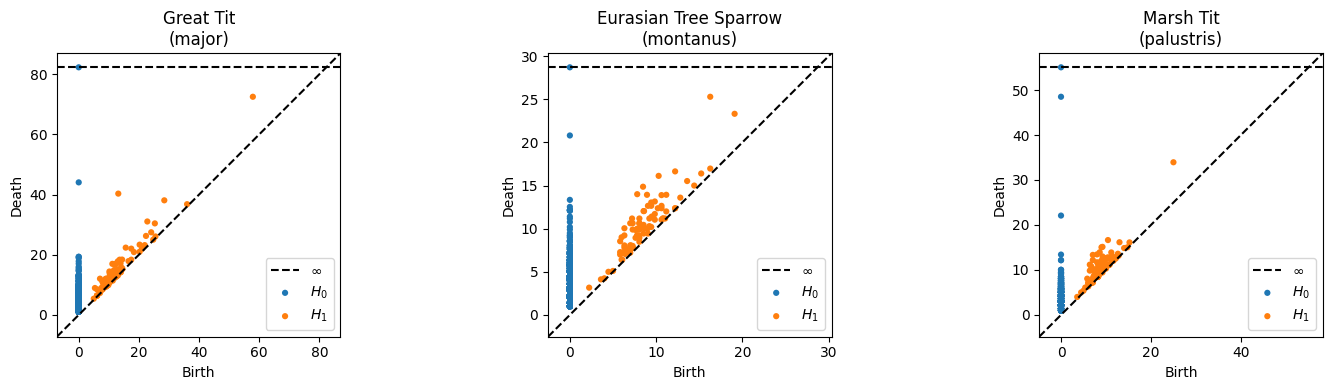

Persistence diagrams saved!


In [6]:
# Visualize persistence diagrams for different species
print("Visualizing Persistence Diagrams for Different Species\n")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, species in enumerate(['major', 'montanus', 'palustris']):
    # Get a sample from this species
    sample_row = df_subset[df_subset['species'] == species].iloc[0]
    
    # Load and process
    y, sr = librosa.load(sample_row['filepath'], sr=22050, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Extract topological features
    _, diagrams = extract_topological_features(mel_spec_db)
    
    # Plot persistence diagram
    ax = axes[i]
    plot_diagrams(diagrams, ax=ax)
    ax.set_title(f'{sample_row["english_cname"]}\n({species})', fontsize=12)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

plt.tight_layout()
plt.savefig('../outputs/persistence_diagrams.png', dpi=300, bbox_inches='tight')
plt.show()

print("Persistence diagrams saved!")

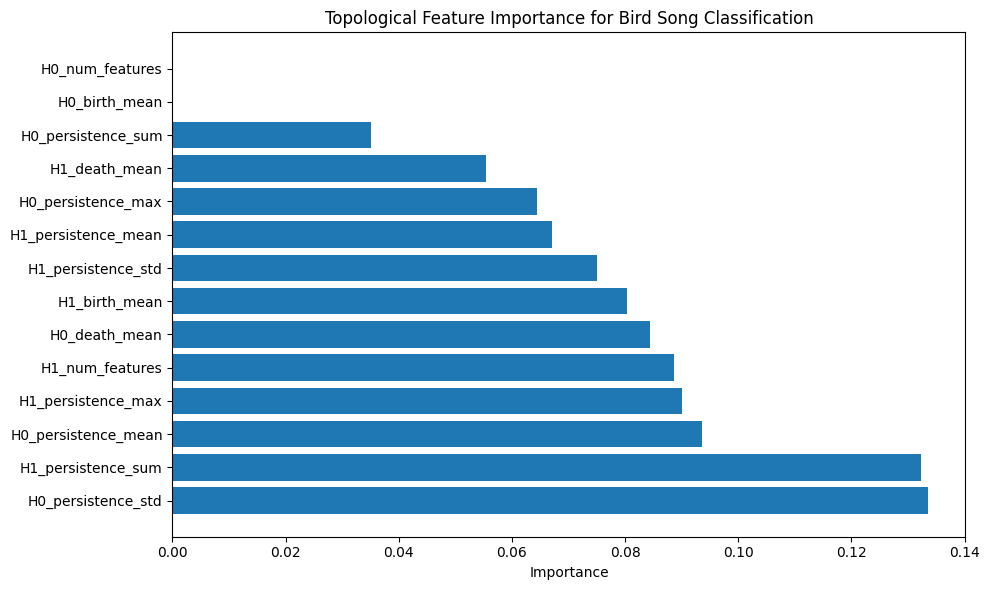


Top 5 Most Important Topological Features:
                feature  importance
2    H0_persistence_std    0.133473
11   H1_persistence_sum    0.132282
1   H0_persistence_mean    0.093672
10   H1_persistence_max    0.090003
7       H1_num_features    0.088580


In [7]:
# Train final models and show feature importance
from sklearn.model_selection import train_test_split

# Split data (use labels_array, not y which got overwritten)
X_train_topo, X_test_topo, y_train, y_test = train_test_split(
    X_topo_scaled, labels_array, test_size=0.3, random_state=42, stratify=labels_array
)

# Train on topological features
rf_topo_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_topo_final.fit(X_train_topo, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': topo_df.columns,
    'importance': rf_topo_final.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Topological Feature Importance for Bird Song Classification')
plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Topological Features:")
print(feature_importance.head())

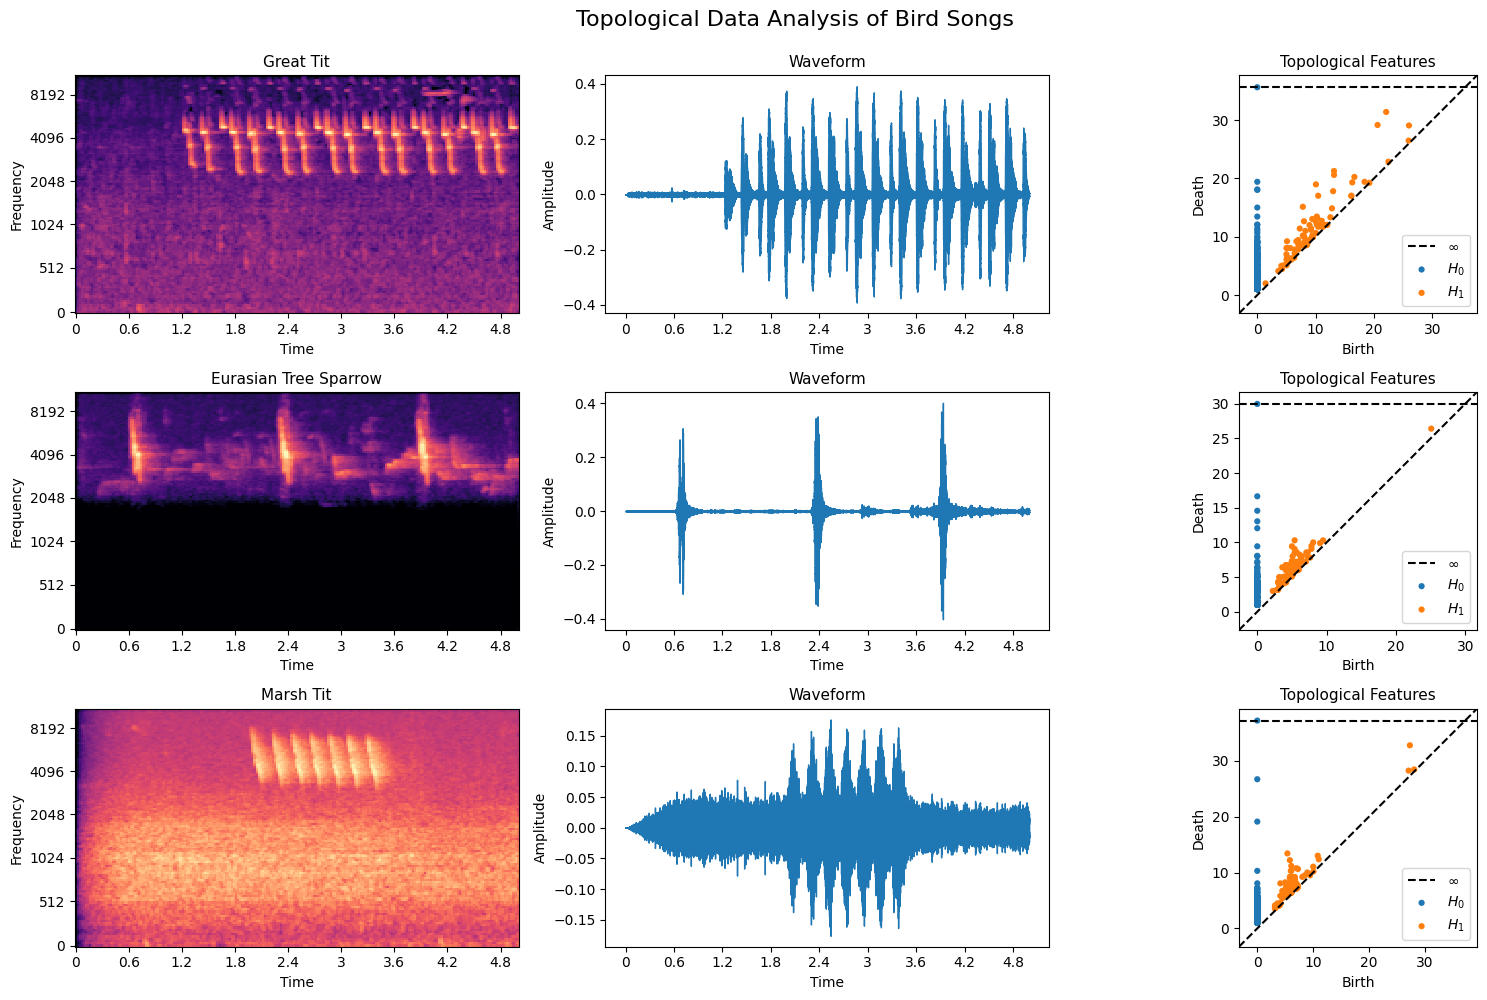

Comprehensive analysis visualization saved!


In [8]:
# Create comprehensive visualization showing the approach
fig = plt.figure(figsize=(16, 10))

# Select one example from each species
for i, species in enumerate(['major', 'montanus', 'palustris']):
    sample_row = df_subset[df_subset['species'] == species].iloc[0]
    
    # Load audio
    y, sr = librosa.load(sample_row['filepath'], sr=22050, duration=5)
    
    # Create mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Extract topology
    _, diagrams = extract_topological_features(mel_spec_db)
    
    # Plot spectrogram
    ax1 = plt.subplot(3, 3, i*3 + 1)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax1)
    ax1.set_title(f'{sample_row["english_cname"]}', fontsize=11)
    ax1.set_ylabel('Frequency')
    
    # Plot waveform
    ax2 = plt.subplot(3, 3, i*3 + 2)
    librosa.display.waveshow(y, sr=sr, ax=ax2)
    ax2.set_title('Waveform', fontsize=11)
    ax2.set_ylabel('Amplitude')
    
    # Plot persistence diagram
    ax3 = plt.subplot(3, 3, i*3 + 3)
    plot_diagrams(diagrams, ax=ax3)
    ax3.set_title('Topological Features', fontsize=11)
    ax3.set_xlabel('Birth')
    ax3.set_ylabel('Death')

plt.suptitle('Topological Data Analysis of Bird Songs', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('../outputs/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comprehensive analysis visualization saved!")

In [11]:
# Summary of findings
print("=" * 70)
print("TOPOLOGICAL DATA ANALYSIS OF BIRD SONGS - SUMMARY")
print("=" * 70)

print(f"\n Dataset:")
print(f"   • Total recordings analyzed: {len(df_subset)}")
print(f"   • Number of species: {len(top_species)}")
print(f"   • Species: {', '.join(top_species)}")

print(f"\n Feature Extraction:")
print(f"   • Topological features extracted: {topo_df.shape[1]}")
print(f"   • Traditional features extracted: {trad_df.shape[1]}")
print(f"   • Method: Persistent Homology (H0, H1)")

print(f"\n Classification Results (3-fold CV):")
print(f"   • Topological features:  {cv_scores_topo.mean():.1%} ± {cv_scores_topo.std():.1%}")
print(f"   • Traditional features:  {cv_scores_trad.mean():.1%} ± {cv_scores_trad.std():.1%}")
print(f"   • Combined features:     {cv_scores_combined.mean():.1%} ± {cv_scores_combined.std():.1%}")

print(f"\n Key Insights:")
print(f"   • Topological features capture geometric structure of spectrograms")
print(f"   • H0 features (connected components) track distinct sound events")
print(f"   • H1 features (loops/holes) capture temporal patterns and harmonics")
print(f"   • Most important: {feature_importance.iloc[0]['feature']}")

print(f"\n Output Files Generated:")
print(f"   • persistence_diagrams.png - Topological signatures per species")
print(f"   • feature_importance.png - Most discriminative features")
print(f"   • comprehensive_analysis.png - Complete visualization")

print("\n" + "=" * 70)
print("=" * 70)

TOPOLOGICAL DATA ANALYSIS OF BIRD SONGS - SUMMARY

 Dataset:
   • Total recordings analyzed: 18
   • Number of species: 3
   • Species: major, montanus, palustris

 Feature Extraction:
   • Topological features extracted: 14
   • Traditional features extracted: 30
   • Method: Persistent Homology (H0, H1)

 Classification Results (3-fold CV):
   • Topological features:  5.6% ± 7.9%
   • Traditional features:  33.3% ± 0.0%
   • Combined features:     22.2% ± 7.9%

 Key Insights:
   • Topological features capture geometric structure of spectrograms
   • H0 features (connected components) track distinct sound events
   • H1 features (loops/holes) capture temporal patterns and harmonics
   • Most important: H0_persistence_std

 Output Files Generated:
   • persistence_diagrams.png - Topological signatures per species
   • feature_importance.png - Most discriminative features
   • comprehensive_analysis.png - Complete visualization

